In [11]:
# ================================
# 03 — UNSUPERVISED AUTOENCODER + RF (FULL PIPELINE)
# ================================

# ---------
# Cell 1: Imports & Config
# ---------
import random, json
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from torchvision import transforms

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib
from sklearn.model_selection import train_test_split

# Import centralized config
import config


In [12]:

# ---------
# Cell 2: Reproducibility & Device
# ---------
random.seed(config.SEED)
np.random.seed(config.SEED)
torch.manual_seed(config.SEED)
torch.cuda.manual_seed_all(config.SEED)

device = config.DEVICE

# Base experiment folder
EXP_DIR = config.EXP_DIR_ROOT / "autoencoder_rf"
EXP_DIR.mkdir(parents=True, exist_ok=True)


In [13]:

# ---------
# Cell 3: Dataset
# ---------
class RamanAEDataset(Dataset):
    def __init__(self, split="train", fps_filter=None):
        all_rows = []

        for mineral_folder in config.RAW_DATA_DIR.iterdir():
            if not mineral_folder.is_dir(): 
                continue
            mineral_name = mineral_folder.name

            for fps_folder in mineral_folder.iterdir():
                if not fps_folder.is_dir(): 
                    continue
                fps_label = fps_folder.name
                if fps_filter and fps_label != fps_filter: 
                    continue
                images = sorted(fps_folder.glob("*.bmp"))

                # On-the-fly split
                train_val, test_imgs = train_test_split(
                    images, test_size=config.TEST_RATIO, random_state=config.SEED
                )
                train_imgs, val_imgs = train_test_split(
                    train_val, test_size=config.VAL_RATIO/(1-config.TEST_RATIO), random_state=config.SEED
                )
                splits = {"train": train_imgs, "val": val_imgs, "test": test_imgs}

                for img_path in splits[split]:
                    all_rows.append({"image": img_path, "mineral": mineral_name, "fps": fps_label})

        self.meta = pd.DataFrame(all_rows)
        self.labels = sorted(self.meta.mineral.unique())
        self.label_map = {l:i for i,l in enumerate(self.labels)}
        self.transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor()
        ])

    def __len__(self): 
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        img = Image.open(row.image).convert("RGB")
        img = self.transform(img)
        label = self.label_map[row.mineral]
        return img, label


In [14]:

# ---------
# Cell 4: Dataloaders
# ---------
def get_dataloaders(fps_label=None):
    train_ds = RamanAEDataset("train", fps_filter=fps_label)
    val_ds   = RamanAEDataset("val", fps_filter=fps_label)
    test_ds  = RamanAEDataset("test", fps_filter=fps_label)

    train_loader = DataLoader(train_ds, batch_size=config.BATCH_SIZE, shuffle=True, pin_memory=True)
    val_loader   = DataLoader(val_ds, batch_size=config.BATCH_SIZE, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=config.BATCH_SIZE, pin_memory=True)

    return train_loader, val_loader, test_loader, train_ds.labels


In [15]:

# ---------
# Cell 5: Autoencoder Definition
# ---------
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(3,16,3,2,1), nn.ReLU(),
            nn.Conv2d(16,32,3,2,1), nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(32,16,4,2,1), nn.ReLU(),
            nn.ConvTranspose2d(16,3,4,2,1), nn.Sigmoid()
        )

    def forward(self,x):
        x = x.to(next(self.parameters()).device)
        z = self.enc(x)
        return self.dec(z), z


In [16]:

# ---------
# Cell 6: Train Autoencoder (resume-safe & save best by val_loss)
# ---------
def train_autoencoder(train_loader, val_loader, exp_dir):
    model = AutoEncoder().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.LR)
    loss_fn = nn.MSELoss()
    best_val_loss = float('inf')
    history = []

    best_model_path = exp_dir / "autoencoder_best.pt"

    # If best model already exists, just load it
    if best_model_path.exists():
        model.load_state_dict(torch.load(best_model_path))
        print(f"Loaded existing AE from {best_model_path}")
        return model, best_model_path, history

    for epoch in range(config.EPOCHS):
        model.train()
        total_loss = 0
        for x,_ in train_loader:
            x = x.to(device, non_blocking=True)
            optimizer.zero_grad()
            x_hat,_ = model(x)
            loss = loss_fn(x_hat,x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x,_ in val_loader:
                x = x.to(device)
                x_hat,_ = model(x)
                val_loss += loss_fn(x_hat,x).item()
        avg_val_loss = val_loss / len(val_loader)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)

        history.append({"epoch": epoch+1, "train_loss": avg_train_loss, "val_loss": avg_val_loss})
        print(f"Epoch {epoch+1}/{config.EPOCHS} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    # Load best model
    model.load_state_dict(torch.load(best_model_path))
    return model, best_model_path, history


In [17]:

# ---------
# Cell 7: Extract Latents to memmap
# ---------
def extract_latents_memmap(model, loader, Z_file, Y_file):
    Z_file_str = str(Z_file.resolve())
    Y_file_str = str(Y_file.resolve())

    # Delete if files already exist
    for f in [Z_file_str, Y_file_str]:
        if Path(f).exists():
            Path(f).unlink()

    first_batch = next(iter(loader))[0]
    latent_dim = model.enc(first_batch.to(device)).flatten(1).shape[1]
    n_samples = len(loader.dataset)

    # Create memmap
    Z_mem = np.memmap(Z_file_str, dtype='float32', mode='w+', shape=(n_samples, latent_dim))
    Y_mem = np.memmap(Y_file_str, dtype='int64', mode='w+', shape=(n_samples,))

    idx = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            _, z = model(x)
            z_flat = z.flatten(1).cpu().numpy()
            batch_size = z_flat.shape[0]
            Z_mem[idx:idx+batch_size] = z_flat
            Y_mem[idx:idx+batch_size] = y.numpy()
            idx += batch_size

    Z_mem.flush()
    Y_mem.flush()
    del Z_mem, Y_mem


In [18]:

# ---------
# Cell 8: Random Forest Training
# ---------
def train_rf(Z_train_file, Y_train_file, Z_test_file, Y_test_file, exp_dir):
    Z_train = np.memmap(str(Z_train_file), dtype='float32', mode='r')
    Y_train = np.memmap(str(Y_train_file), dtype='int64', mode='r')
    Z_test  = np.memmap(str(Z_test_file), dtype='float32', mode='r')
    Y_test  = np.memmap(str(Y_test_file), dtype='int64', mode='r')

    # Reshape Z
    latent_dim = Z_train.shape[1] if len(Z_train.shape)==2 else int(Z_train.size / len(Y_train))
    Z_train = np.reshape(Z_train, (-1, latent_dim))
    Z_test  = np.reshape(Z_test, (-1, latent_dim))

    rf = RandomForestClassifier(n_estimators=200, random_state=config.SEED)
    rf.fit(Z_train, Y_train)
    preds = rf.predict(Z_test)
    acc = accuracy_score(Y_test, preds)

    # Save RF
    joblib.dump(rf, exp_dir / "rf.pkl")
    print(f"RF Test Accuracy: {acc:.4f}")
    with open(exp_dir / "metrics.json", "w") as f:
        json.dump({"accuracy": acc}, f)

    return acc


In [19]:

# ---------
# Cell 9: Full Pipeline per FPS
# ---------
def autoencoder_rf_pipeline(fps_label):
    print(f"\n=== Running pipeline for {fps_label} ===")
    train_loader, val_loader, test_loader, labels = get_dataloaders(fps_label)

    exp_dir = EXP_DIR / fps_label
    exp_dir.mkdir(parents=True, exist_ok=True)

    # Train AE (resume-safe)
    ae_model, best_model_path, history = train_autoencoder(train_loader, val_loader, exp_dir)
    print(f"Saved best AE to {best_model_path}")

    # Save AE train/val history (optional)
    with open(exp_dir / "ae_history.json", "w") as f:
        json.dump(history, f, indent=2)

    # Latent memmap paths
    Ztr_file = exp_dir / "Z_train.dat"
    Ytr_file = exp_dir / "Y_train.dat"
    Zte_file = exp_dir / "Z_test.dat"
    Yte_file = exp_dir / "Y_test.dat"

    # Extract latents
    extract_latents_memmap(ae_model, train_loader, Ztr_file, Ytr_file)
    extract_latents_memmap(ae_model, test_loader,  Zte_file, Yte_file)

    # Train RF
    acc = train_rf(Ztr_file, Ytr_file, Zte_file, Yte_file, exp_dir)
    print(f"Pipeline complete for {fps_label} - Test Accuracy: {acc:.4f}")


In [20]:

# ---------
# Cell 10: Run Pipelines for Both FPS
# ---------
for fps in ["1fps","30fps"]:
    autoencoder_rf_pipeline(fps)



=== Running pipeline for 1fps ===
Loaded existing AE from R:\MUL\Courses\Applied ML\raman-mineral-classification\experiments\autoencoder_rf\1fps\autoencoder_best.pt
Saved best AE to R:\MUL\Courses\Applied ML\raman-mineral-classification\experiments\autoencoder_rf\1fps\autoencoder_best.pt
RF Test Accuracy: 1.0000
Pipeline complete for 1fps - Test Accuracy: 1.0000

=== Running pipeline for 30fps ===
Epoch 1/5 - Train Loss: 0.1351 - Val Loss: 0.0357
Epoch 2/5 - Train Loss: 0.0346 - Val Loss: 0.0309
Epoch 3/5 - Train Loss: 0.0297 - Val Loss: 0.0273
Epoch 4/5 - Train Loss: 0.0249 - Val Loss: 0.0236
Epoch 5/5 - Train Loss: 0.0117 - Val Loss: 0.0023
Saved best AE to R:\MUL\Courses\Applied ML\raman-mineral-classification\experiments\autoencoder_rf\30fps\autoencoder_best.pt
RF Test Accuracy: 1.0000
Pipeline complete for 30fps - Test Accuracy: 1.0000



📌 Testing pipeline for 1fps
✅ Test Accuracy (1fps): 1.0000

📄 Classification Report:
              precision    recall  f1-score   support

       Albit       1.00      1.00      1.00        73
     Calcite       1.00      1.00      1.00        69
     Dolomit       1.00      1.00      1.00        71
    Feldspat       1.00      1.00      1.00        72
       Quarz       1.00      1.00      1.00        74
Rhodocrosite       1.00      1.00      1.00        69
        Tile       1.00      1.00      1.00        69

    accuracy                           1.00       497
   macro avg       1.00      1.00      1.00       497
weighted avg       1.00      1.00      1.00       497



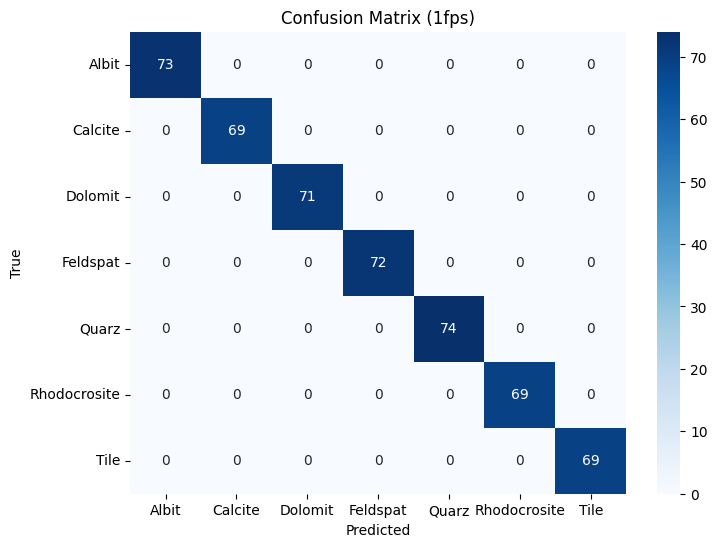


📌 Testing pipeline for 30fps
✅ Test Accuracy (30fps): 1.0000

📄 Classification Report:
              precision    recall  f1-score   support

       Albit       1.00      1.00      1.00        72
     Calcite       1.00      1.00      1.00        61
     Dolomit       1.00      1.00      1.00        77
    Feldspat       1.00      1.00      1.00        76
       Quarz       1.00      1.00      1.00        74
Rhodocrosite       1.00      1.00      1.00        74
        Tile       1.00      1.00      1.00        72

    accuracy                           1.00       506
   macro avg       1.00      1.00      1.00       506
weighted avg       1.00      1.00      1.00       506



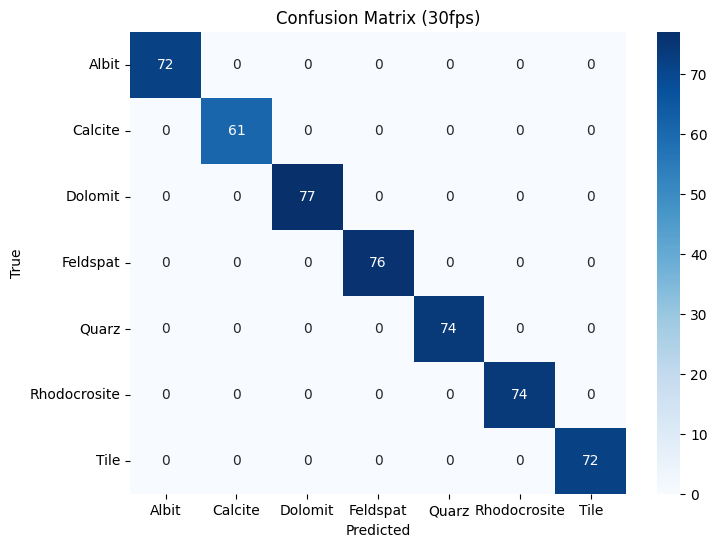


📊 Final Test Accuracies
1 FPS  → 1.0000
30 FPS → 1.0000


In [22]:
# ================================
# TEST PIPELINE + PLOTS
# ================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import joblib

# -------------------------------
# Function to test a single FPS
# -------------------------------
def test_autoencoder_rf(fps_label):
    print(f"\n📌 Testing pipeline for {fps_label}")

    exp_dir = config.EXP_DIR_ROOT / "autoencoder_rf" / fps_label

    # Load AE
    ae_model = AutoEncoder().to(device)
    ae_model.load_state_dict(torch.load(exp_dir / "autoencoder_best.pt"))
    ae_model.eval()

    # Load RF
    rf_model = joblib.load(exp_dir / "rf.pkl")

    # Load memmap
    Z_test_file = exp_dir / "Z_test.dat"
    Y_test_file = exp_dir / "Y_test.dat"

    # Load Y (simple 1D)
    Y_test  = np.memmap(str(Y_test_file), dtype='int64', mode='r')

    # Infer latent_dim from AE first batch
    test_loader = DataLoader(RamanAEDataset("test", fps_filter=fps_label), batch_size=1)
    first_batch, _ = next(iter(test_loader))
    latent_dim = ae_model.enc(first_batch.to(device)).flatten(1).shape[1]

    # Load Z memmap and reshape correctly
    total_samples = len(Y_test)
    Z_test  = np.memmap(str(Z_test_file), dtype='float32', mode='r')
    Z_test  = np.reshape(Z_test, (total_samples, latent_dim))

    # Predict
    y_pred = rf_model.predict(Z_test)
    y_true = np.array(Y_test)

    acc = accuracy_score(y_true, y_pred)
    print(f"✅ Test Accuracy ({fps_label}): {acc:.4f}\n")

    # Classification report
    labels = sorted(RamanAEDataset("test", fps_filter=fps_label).labels)
    print("📄 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=labels))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix ({fps_label})")
    plt.show()

    return acc, cm

# -------------------------------
# Run for both FPS
# -------------------------------
acc_1fps, cm_1fps = test_autoencoder_rf("1fps")
acc_30fps, cm_30fps = test_autoencoder_rf("30fps")

print("\n📊 Final Test Accuracies")
print(f"1 FPS  → {acc_1fps:.4f}")
print(f"30 FPS → {acc_30fps:.4f}")
